In [1]:
from enum import Enum
import numpy as np
from sklearn.utils import Bunch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn import metrics
import math
import lime
import lime.lime_tabular
from sklearn.linear_model import Ridge
import random 
from scipy.special import gammainccinv, erfinv
from sklearn.metrics import pairwise_distances
import pandas as pd
from matplotlib.patches import Ellipse
from scipy.stats import chi2, norm
from numpy.random import default_rng
from types import LambdaType


class Dataset(Enum):
  GENERATED = 'Generated'
  BLOBS = 'Blobs'
  IRIS2D = 'Iris (2D)'
  IRIS = 'Iris'
  BC = 'Breast cancer'
  PIMA = 'Pima Indian'
  WINE = 'Wine'

  @property
  def instance(self):
    if self == Dataset.GENERATED:
      amount = 2500
      data = np.random.uniform(0,[3,10],(amount,2))
      return Bunch(
        data=data,
        feature_names=['feature 1', 'feature 2'],
        target_names=['yellow', 'blue'],
        target=(np.logical_and(data[:,0]>1, data[:,1]>2)).astype(int)
      )

    if self == Dataset.BLOBS:
      from sklearn.datasets import make_blobs
      amount = 250
      X,y = make_blobs(amount, n_features = 3, centers = 4)
      return Bunch(
        data=X,
        feature_names=['feature 1', 'feature 2', 'feature 3'],
        target_names=['yellow', 'blue'],
        target=(y>1).astype(int)
      )

    if self == Dataset.IRIS2D:
      from sklearn.datasets import load_iris
      dataset = load_iris()
      indexes = np.array([0,1])
      dataset.data = dataset.data[:, indexes]
      dataset.feature_names = np.array(dataset.feature_names)[indexes]
      return dataset

    if self == Dataset.IRIS:
      from sklearn.datasets import load_iris
      return load_iris()

    if self == Dataset.BC:
      from sklearn.datasets import load_breast_cancer
      dataset = load_breast_cancer()
      return dataset

    if self == Dataset.WINE:
      from sklearn.datasets import load_wine
      dataset = load_wine()
      return dataset
    
    if self == Dataset.PIMA:
      from sklearn.datasets import load_diabetes
      dataset = load_diabetes()
      dataset.target = (dataset.target > 200).astype(int)
      return dataset


class Classifier(Enum):
  DT = 'Decision tree'
  RF = 'Random Forest'
  MLP = 'Perceptron'
  GNB = 'Naive Bayes'
  SVM = 'Support vector machine'
  QDA = 'Quadratic Discriminant Analysis'

  @property
  def instance(self):
    if self == Classifier.DT:
      from sklearn.tree import DecisionTreeClassifier
      return DecisionTreeClassifier(random_state=1)
    if self == Classifier.RF:
      from sklearn.ensemble import RandomForestClassifier
      return RandomForestClassifier(random_state=1, n_estimators=200)
    elif self == Classifier.MLP:
      from sklearn.neural_network import MLPClassifier
      return MLPClassifier(alpha=0.1, hidden_layer_sizes=(100,100,100))
    elif self == Classifier.GNB:
      from sklearn.naive_bayes import GaussianNB
      return GaussianNB()
    elif self == Classifier.SVM:
      from sklearn.svm import SVC
      return SVC(probability=True)
    elif self == Classifier.QDA:
      from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
      return QuadraticDiscriminantAnalysis()

In [2]:
from sklearn.preprocessing import normalize
from bisect import bisect
from scipy.optimize import newton
from functools import partial
from sklearn.linear_model import Ridge
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler, MinMaxScaler


class LemonExplainer(object):
  """
  Intantiates the explainer.
  """
  def __init__(self, training_data, distance_kernel=None, sample_size = 5000, radius_max=1, random_state=None):
    self.random_state = check_random_state(random_state)
    np.random.seed(random_state)

    self.training_data = training_data
    self.scaler = StandardScaler(with_mean=False)
    self.scaler.fit(training_data)
    
    # Create hypersphere samples. The sphere is only computed once for performance and stability,
    # but it would be better to resample the sphere every time `explain_instance` is called.
    # I checked, this does not affect the results in any way.
    dimensions = training_data.shape[1]

    if distance_kernel is None:
      self.distance_kernel = np.vectorize(lambda x: x ** (1 / dimensions))
    else:
      self.distance_kernel = np.vectorize(self._transform(distance_kernel, dimensions, radius_max=radius_max))

    sphere = np.random.normal(size=(sample_size, dimensions))
    sphere = normalize(sphere)
    sphere *= self.distance_kernel(np.random.uniform(size=sample_size)).reshape(-1,1)
    
    self.sphere = sphere

  @property
  def surrogate(self):
    try:
      return self._surrgate
    except AttributeError:
      self._surrogate = Ridge(alpha=0, fit_intercept=True, normalize=True, random_state=self.random_state)
      return self._surrogate

  def explain_instance(self, instance, predict_fn, labels=(1,), surrogate=None):
    surrogate = surrogate or self.surrogate
  
    # Create transfer dataset by perturbing the original instance with the hypersphere samples
    X_transfer = self.scaler.inverse_transform(self.sphere) + np.array([instance])
    y_transfer = predict_fn(X_transfer)

    def explain_label(label):
      surrogate.fit(X_transfer, y_transfer[:,label])
      score = surrogate.score(X_transfer, y_transfer[:,label])
      return (surrogate.coef_, score)

    return [explain_label(label) for label in labels]

  def _transform(self, kernel, dimensions, sample_size = 1000, radius_max=1): 
    """
    Inverse transform sampling
    """
    cdf_samples = np.array([kernel(x)*(x**(dimensions-1)) for x in np.linspace(0, radius_max, sample_size)])
    cdf_samples = np.cumsum(cdf_samples)
    cdf_samples /= cdf_samples[-1]
    return lambda y: radius_max * (bisect(cdf_samples, y) / sample_size)


def uniform_kernel(x):
    return 1


def gaussian_kernel(x, kernel_width):
    # https://github.com/marcotcr/lime/blob/fd7eb2e6f760619c29fca0187c07b82157601b32/lime/lime_tabular.py#L251
    return np.sqrt(np.exp(-(x ** 2) / kernel_width ** 2))

  
def sqcos_kernel(x):
    return np.cos(x)**2

  
def trapezoid_kernel(x, a, b):
    if 0 <= x and  x <= a:
        return (2 / (a + b))
    elif a <= x and x <= b:
        return (2 / (a + b)) * ((b - x) / (b - a))
    else: 
        return 0

In [3]:
# For the `plot_sample_data` debug feature in the next cell, you need to patch LIME as such:

# Change return statement from `explain_instance_with_data` (lime_base.py:204) to

#         return (easy_model.intercept_,
#                 sorted(zip(used_features, easy_model.coef_),
#                        key=lambda x: np.abs(x[1]), reverse=True),
#                 prediction_score, local_pred, neighborhood_data[:, used_features], weights)
                
# And `ret_exp` in `explain_instance` (lime_tabular.py:450) to

#             (ret_exp.intercept[label],
#              ret_exp.local_exp[label],
#              ret_exp.score, ret_exp.local_pred, ret_exp.data, ret_exp.weights) = self.base.explain_instance_with_data(
#                     scaled_data,
#                     yss,
#                     distances,
#                     label,
#                     num_features,
#                     model_regressor=model_regressor,
#                     feature_selection=self.feature_selection)

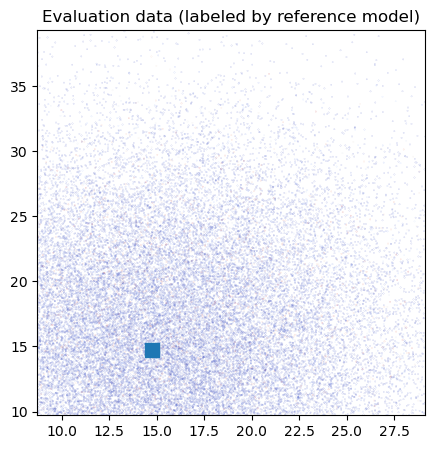

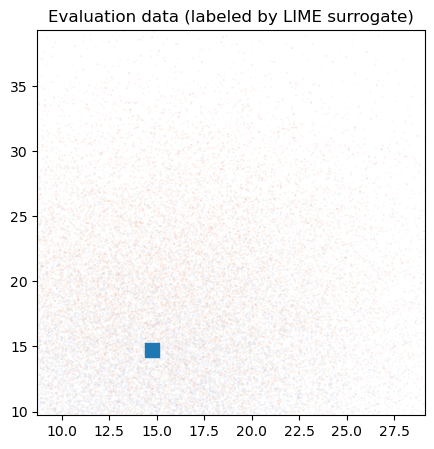

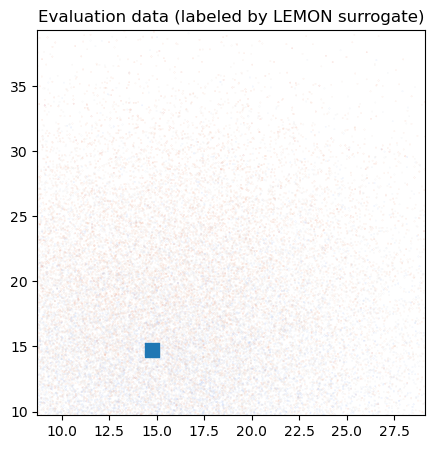

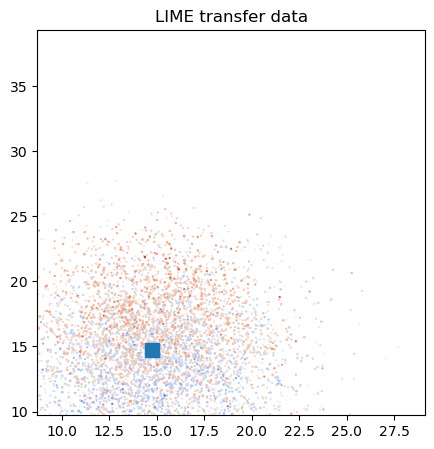

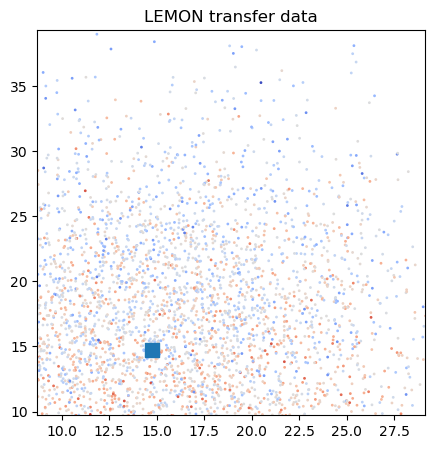

(array([[0.        , 0.16804365]]), array([[0.        , 0.54545653]]))

In [4]:
def do_experiment(Xtr, classifier, KERNEL_SIZE, plot_sample_data=False):
  from scipy.special import gammainccinv, erfinv
  sample_size_lime = 5000
  sample_size_lemon = 5000
  
  DIMENSIONS = Xtr.shape[1]
  p = 0.999
  
  if type(KERNEL_SIZE) is LambdaType:
    KERNEL_SIZE = KERNEL_SIZE(DIMENSIONS)

  kernel_width_lime = KERNEL_SIZE
  radius = KERNEL_SIZE * np.sqrt(2*gammainccinv(DIMENSIONS/2, (1-p)))
  kernel_width_lemon = KERNEL_SIZE
  diameter = radius * 2

  # explainers
  surrogate_lime = Ridge(fit_intercept=True, random_state=123)
  explainer_lime = lime.lime_tabular.LimeTabularExplainer(
      Xtr, 
      kernel_width=kernel_width_lime,
      feature_selection='none',
      sample_around_instance=True, # Important! Essentially: True = synthetic, False = observation-based sampling
      discretize_continuous=False
  )

  surrogate_lemon = Ridge(fit_intercept=True, random_state=123)
  explainer_lemon = LemonExplainer(
      Xtr, 
      sample_size=sample_size_lemon, 
      distance_kernel=partial(gaussian_kernel, kernel_width=kernel_width_lemon),
      radius_max=radius
  )

  Xeval = Xtr
  yeval = classifier.predict_proba(Xeval)
  ceval = classifier.predict(Xeval)
  scaled_data = explainer_lime.scaler.transform(Xeval)

  points = []
  points2 = []

  # for many test instances
  for i in range(0, Xeval.shape[0]): 
      testInstance = (Xeval[i,:], classifier.predict(Xeval[i,:].reshape(1, -1))[0])

      explanation_lime = explainer_lime.explain_instance(
          testInstance[0], 
          classifier.predict_proba, 
          num_samples=sample_size_lime, 
          labels=(testInstance[1],), 
          model_regressor=surrogate_lime
      )

      explanation_lemon = explainer_lemon.explain_instance(
          testInstance[0], 
          classifier.predict_proba,
          labels=(testInstance[1],),
          surrogate=surrogate_lemon
      )
      
      ## Misleading: self-reported scores from LIME and LEMON
      # lime_fidelity = explanation_lime.score
      # lemon_fidelity = explanation_lemon[0][1]

      ## Generate 50000 new samples in the neighborhood to compute R^2 between reference and surrogate models.
      sample_size = 50000
      dimensions = DIMENSIONS
      sphere = np.random.normal(size=(sample_size, dimensions))
      sphere = normalize(sphere)
      sphere *= explainer_lemon.distance_kernel(np.random.uniform(size=sample_size)).reshape(-1,1)
      X_transfer = explainer_lemon.scaler.inverse_transform(sphere) + np.array([testInstance[0]])
      y_transfer = classifier.predict_proba(X_transfer)

      from sklearn.metrics import mean_squared_error
      lemon_fidelity = mean_squared_error(
        y_transfer[:,testInstance[1]],
        surrogate_lemon.predict(X_transfer),
        squared=False
      )
      
      scaled = (X_transfer - explainer_lime.scaler.mean_) / explainer_lime.scaler.scale_
      lime_fidelity = mean_squared_error(
        y_transfer[:,testInstance[1]],
        surrogate_lime.predict(scaled),
        squared=False
      )
      
      points.append([i, lemon_fidelity])
      points2.append([i, lime_fidelity])

      # Plot sampled points
      if plot_sample_data:
        from matplotlib.patches import Ellipse
        slice = (0,1)

        # Evaluation data
        if 'sphere' in vars():
          # Evaluation data (labeled by reference model)
          plt.figure(figsize=(5, 5))
          plt.xlim(np.min(Xtr[:,slice[0]]) + 1, np.max(Xtr[:,slice[0]]) + 1)
          plt.ylim(np.min(Xtr[:,slice[1]]), np.max(Xtr[:,slice[1]]))

          plt.scatter(X_transfer[:,slice[0]], X_transfer[:,slice[1]], cmap='coolwarm', s=0.005, c=y_transfer[:,1])
          plt.title("Evaluation data (labeled by reference model)")

          w, h = explainer_lemon.scaler.inverse_transform([np.repeat(diameter, DIMENSIONS)])[0, slice]
          plot = plt.scatter(testInstance[0][slice[0]], testInstance[0][slice[1]], s=100, marker='s')
          circle = Ellipse((testInstance[0][slice[0]], testInstance[0][slice[1]]), width=w, height=h, color='r', fill=False)
          plot.axes.add_artist(circle)
          plt.show()
          
          # Evaluation data (labeled by LIME surrogate)
          plt.figure(figsize=(5, 5))
          plt.xlim(np.min(Xtr[:,slice[0]]) + 1, np.max(Xtr[:,slice[0]]) + 1)
          plt.ylim(np.min(Xtr[:,slice[1]]), np.max(Xtr[:,slice[1]]))

          plt.scatter(X_transfer[:,slice[0]], X_transfer[:,slice[1]], cmap='coolwarm', s=0.005, c=surrogate_lime.predict((X_transfer - explainer_lime.scaler.mean_) / explainer_lime.scaler.scale_))
          plt.title("Evaluation data (labeled by LIME surrogate)")

          w, h = explainer_lemon.scaler.inverse_transform([np.repeat(diameter, DIMENSIONS)])[0, slice]
          plot = plt.scatter(testInstance[0][slice[0]], testInstance[0][slice[1]], s=100, marker='s')
          circle = Ellipse((testInstance[0][slice[0]], testInstance[0][slice[1]]), width=w, height=h, color='r', fill=False)
          plot.axes.add_artist(circle)
          plt.show()
          
          # Evaluation data (labeled by LEMON surrogate)
          plt.figure(figsize=(5, 5))
          plt.xlim(np.min(Xtr[:,slice[0]]) + 1, np.max(Xtr[:,slice[0]]) + 1)
          plt.ylim(np.min(Xtr[:,slice[1]]), np.max(Xtr[:,slice[1]]))

          plt.scatter(X_transfer[:,slice[0]], X_transfer[:,slice[1]], cmap='coolwarm', s=0.005, c=surrogate_lemon.predict(X_transfer))
          plt.title("Evaluation data (labeled by LEMON surrogate)")

          w, h = explainer_lemon.scaler.inverse_transform([np.repeat(diameter, DIMENSIONS)])[0, slice]
          plot = plt.scatter(testInstance[0][slice[0]], testInstance[0][slice[1]], s=100, marker='s')
          circle = Ellipse((testInstance[0][slice[0]], testInstance[0][slice[1]]), width=w, height=h, color='r', fill=False)
          plot.axes.add_artist(circle)
          plt.show()

        # LIME
        plt.figure(figsize=(5, 5))
        plt.xlim(np.min(Xtr[:,slice[0]]) + 1, np.max(Xtr[:,slice[0]]) + 1)
        plt.ylim(np.min(Xtr[:,slice[1]]), np.max(Xtr[:,slice[1]]))

        data = (explanation_lime.data * explainer_lime.scaler.scale_) + explainer_lime.scaler.mean_
        ax = plt.scatter(data[:,slice[0]], data[:,slice[1]], cmap='coolwarm', s=np.around(explanation_lime.weights*10, decimals=7), c=surrogate_lime.predict(explanation_lime.data))
        plt.title("LIME transfer data")

        w, h = explainer_lime.scaler.inverse_transform([np.repeat(diameter, DIMENSIONS)])[0, slice]
        plot = plt.scatter(testInstance[0][slice[0]], testInstance[0][slice[1]], s=100, marker='s' )
        circle = Ellipse((testInstance[0][slice[0]], testInstance[0][slice[1]]), width=w, height=h, color='r', fill=False)
        plot.axes.add_artist(circle)
        plt.show()

        # LEMON
        plt.figure(figsize=(5, 5))
        plt.xlim(np.min(Xtr[:,slice[0]]) + 1, np.max(Xtr[:,slice[0]]) + 1)
        plt.ylim(np.min(Xtr[:,slice[1]]), np.max(Xtr[:,slice[1]]))

        X_transfer = explainer_lemon.scaler.inverse_transform(explainer_lemon.sphere) + np.array([testInstance[0]])
        plt.scatter(X_transfer[:,slice[0]], X_transfer[:,slice[1]], cmap='coolwarm', s=1, c=1 - surrogate_lemon.predict(X_transfer))
        plt.title("LEMON transfer data")
        
        w, h = explainer_lemon.scaler.inverse_transform([np.repeat(diameter, DIMENSIONS)])[0, slice]
        plot = plt.scatter(testInstance[0][slice[0]], testInstance[0][slice[1]], s=100, marker='s')
        circle = Ellipse((testInstance[0][slice[0]], testInstance[0][slice[1]]), width=w, height=h, color='r', fill=False)
        plot.axes.add_artist(circle)
        plt.show()
        
        # return early
        return np.array(points), np.array(points2)
        
  return np.array(points), np.array(points2)


## Sanity check (This requires patching LIME! See previous cell.)
# data = Dataset.IRIS.instance
# default_rng(seed=2).shuffle(data.data)
# Xtr, Xte, ytr, yte = train_test_split(data.data, data.target, test_size=0.6, random_state=123)
# classifier = Classifier.GNB.instance
# classifier.fit(Xtr, ytr)
# do_experiment(Xtr, classifier, 0.2, plot_sample_data=True)

data = Dataset.BC.instance
default_rng(seed=2).shuffle(data.data)
Xtr, Xte, ytr, yte = train_test_split(data.data, data.target, test_size=0.6, random_state=123)
classifier = Classifier.GNB.instance
classifier.fit(Xtr, ytr)
do_experiment(Xtr, classifier, 2, plot_sample_data=True)

In [5]:
# Single-core version

# from tqdm.notebook import tqdm

# datasets = [
# #  Dataset.IRIS2D,
#   Dataset.WINE,
#   Dataset.PIMA,
#   Dataset.BC
# ]

# classifiers = [
#   Classifier.GNB,
#   Classifier.MLP,
#   Classifier.RF
# ]

# kernel_widths = [
#   0.1,
#   0.2,
#   0.3,
#   # 0.4,
#   0.5,
#   # 0.6,
#   # 0.7,
#   # 0.8,
#   # 0.9,
#   1.0,
#   # 1.5,
#   2.0,
#   # 2.5,
#   # 3.0,
#   # 3.5,
#   4.0
# ]

# columns = pd.MultiIndex.from_product([datasets, classifiers])
# results_lime = pd.DataFrame(0, columns=columns, index=kernel_widths)
# results_lemon = pd.DataFrame(0, columns=columns, index=kernel_widths)

# for dataset in tqdm(datasets, position=0, desc="datasets", leave=False):
#   for classifier in tqdm(classifiers, position=1, desc="classifiers", leave=False):
#     data = dataset.instance
#     Xtr = data.data
#     clf = classifier.instance
#     clf.fit(Xtr, data.target)                           

#     for kernel_width in tqdm(kernel_widths, position=2, desc="kernel_widths", leave=False):
#       #print(dataset, classifier, kernel_width)
#       points, points2 = do_experiment(Xtr, clf, kernel_width, plot_sample_data=False)
#       score_lemon = np.mean(points[:,1])
#       score_lime = np.mean(points2[:,1])
#       #print("Mean R^2 LEMON: ", score_lemon)
#       #print("Mean R^2 LIME: ", score_lime)
#       results_lime.loc[kernel_width, (dataset, classifier)] = score_lime
#       results_lemon.loc[kernel_width, (dataset, classifier)] = score_lemon

In [6]:
# Multi-core version

from tqdm.notebook import tqdm

datasets = [
#  Dataset.IRIS2D,
  Dataset.WINE,
  Dataset.PIMA,
  Dataset.BC
]

classifiers = [
  Classifier.GNB,
  Classifier.MLP,
  Classifier.RF
]

kernel_widths = [
  0.1,
  # 0.2,
  0.3,
  # 0.4,
  0.5,
  # 0.6,
  # 0.7,
  # 0.8,
  # 0.9,
  1.0,
  # 1.5,
  # 2.0,
  # 2.5,
  # 3.0,
  # 3.5,
  lambda n: np.sqrt(n) * .75,
  4.0
]

columns = pd.MultiIndex.from_product([datasets, classifiers])

def faithfulness(options):
  dataset, classifier, kernel_width = options
  data = dataset.instance
  Xtr = data.data
  clf = classifier.instance
  clf.fit(Xtr, data.target)                           
  
  points, points2 = do_experiment(Xtr, clf, kernel_width, plot_sample_data=False)
  score_lemon = np.mean(points[:,1])
  score_lime = np.mean(points2[:,1])
  
  return score_lime, score_lemon


import contextlib
import joblib
from tqdm.notebook import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()
        
        
from itertools import product
from joblib import delayed, Parallel, cpu_count

parameters = list(product(datasets, classifiers, kernel_widths))


with tqdm_joblib(tqdm(total=len(parameters))) as progress_bar:
  result = Parallel(n_jobs=cpu_count())(delayed(faithfulness)(p) for p in parameters)
  result

In [7]:
kernel_widths_cleaned = ['0.75*sqrt(n)' if type(k) is LambdaType else k for k in kernel_widths]
results_lime = pd.DataFrame(0, columns=columns, index=kernel_widths_cleaned)
results_lemon = pd.DataFrame(0, columns=columns, index=kernel_widths_cleaned)
for i, (dataset, classifier, kernel_width) in enumerate(parameters):
  score_lime = result[i][0]
  score_lemon = result[i][1]
  results_lime.loc['0.75*sqrt(n)' if type(kernel_width) is LambdaType else kernel_width, (dataset, classifier)] = score_lime
  results_lemon.loc['0.75*sqrt(n)' if type(kernel_width) is LambdaType else kernel_width, (dataset, classifier)] = score_lemon

In [8]:
results_lime

Dataset.WINE                                Dataset.PIMA  \
             Classifier.GNB Classifier.MLP Classifier.RF Classifier.GNB   
0.1                0.008989       0.036372      0.041240       0.018217   
0.3                0.043805       0.146913      0.118048       0.057032   
0.5                0.103414       0.283374      0.185719       0.079200   
1.0                0.258347       0.272925      0.156446       0.119811   
0.75*sqrt(n)       0.651999       0.543447      0.376252       0.386809   
4.0                0.848083       0.827159      0.545138       0.686167   

                                              Dataset.BC                 \
             Classifier.MLP Classifier.RF Classifier.GNB Classifier.MLP   
0.1                0.017151      0.072158       0.011035       0.221575   
0.3                0.050881      0.141162       0.051758       0.400797   
0.5                0.072818      0.111955       0.150611       0.458107   
1.0                0.067642      0.104478       0.490496       0.585191   
0.75*sqrt(n)       0.238953      0.246642       0.512389       0.781118   
4.0                0.451867      0.419035       0.504270       1.162143   

                            
             Classifier.RF  
0.1               0.037692  
0.3               0.102751  
0.5               0.170892  
1.0               0.264971  
0.75*sqrt(n)      0.366677  
4.0               0.357970

In [9]:
results_lemon

Dataset.WINE                                Dataset.PIMA  \
             Classifier.GNB Classifier.MLP Classifier.RF Classifier.GNB   
0.1                0.003416       0.006564      0.017829       0.016376   
0.3                0.026438       0.079406      0.050731       0.031268   
0.5                0.070694       0.143258      0.082043       0.045320   
1.0                0.223747       0.246602      0.120056       0.109958   
0.75*sqrt(n)       0.302913       0.270875      0.123706       0.256561   
4.0                0.282160       0.306657      0.119551       0.348526   

                                              Dataset.BC                 \
             Classifier.MLP Classifier.RF Classifier.GNB Classifier.MLP   
0.1                0.015369      0.035602       0.005870       0.101673   
0.3                0.026250      0.052779       0.030243       0.208439   
0.5                0.032323      0.064401       0.104499       0.229276   
1.0                0.063180      0.088226       0.263305       0.312423   
0.75*sqrt(n)       0.146445      0.100282       0.001366       0.330564   
4.0                0.192423      0.096450       0.002000       0.304686   

                            
             Classifier.RF  
0.1               0.014776  
0.3               0.038158  
0.5               0.057413  
1.0               0.072383  
0.75*sqrt(n)      0.065191  
4.0               0.065356

In [10]:
np.mean(np.mean((results_lime - results_lemon) / results_lime))

0.5075041660842103